Generate material maps using an existing model checkpoint.

In [29]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio.plot
import torch.utils.data
import torchgeo.datasets
import tqdm
from lightning import Trainer
from torchgeo.samplers import GridGeoSampler

from classification.datamodules import TrainingDataModule
from classification.datasets import TrainingDataset
from classification.task import TrainingTask

In [30]:
# Enable TF32 support.
torch.set_float32_matmul_precision("high")
torch.backends.cudnn.allow_tf32 = True

### Testing

In [31]:
# Instantiate the model in inference mode.
model: TrainingTask = TrainingTask.load_from_checkpoint("logs/RoofSense/best-v1.ckpt")
# NOTE: This command disables all batch normalization and dropout layers.
model.eval()

# Instantiate the datamodule.
datamodule = TrainingDataModule(root="../annotation/data", batch_size=64, patch_size=64, num_workers=8)

# Instantiate the trainer.
trainer = Trainer(benchmark=True)

weights
['weights', 'ignore']


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [32]:
# Test the model.
# FIXME: Do not log.
trainer.test(model, datamodule=datamodule)

Missing logger folder: C:\Documents\RoofSense\classification\lightning_logs
C:\Documents\RoofSense\classification\datasets.py:198: UserWarning: The spatial index of the dataset is being populated. This operation may require a considerable amount of time to complete.
  warnings.warn(msg, UserWarning)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.11713717132806778    │
│    test_macroAccuracy     │    0.32247766852378845    │
│     test_macroF1Score     │    0.3263855278491974     │
│       test_macroIoU       │    0.31972143054008484    │
│    test_macroPrecision    │    0.33038926124572754    │
│     test_macroRecall      │    0.32247766852378845    │
│    test_microAccuracy     │    0.9591643214225769     │
│     test_microF1Score     │    0.9591643214225769     │
│       test_microIoU       │    0.9215328693389893     │
│    test_microPrecision    │    0.9591643214225769     │
│     test_microRecall      │    0.9591643214225769     │
│   test_weightedAccuracy   │    0.9591643214225769     │
│   test_weightedF1Score    │    0.9707877039909363     │
│     test_weightedIoU      │    0.9509663581848145     │
│  test_weightedPrecision   │    0.9826962947845459     │
│    test_weightedRecall    │    0.9591643214225769     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.11713717132806778,
  'test_macroAccuracy': 0.32247766852378845,
  'test_macroF1Score': 0.3263855278491974,
  'test_macroIoU': 0.31972143054008484,
  'test_macroPrecision': 0.33038926124572754,
  'test_macroRecall': 0.32247766852378845,
  'test_microAccuracy': 0.9591643214225769,
  'test_microF1Score': 0.9591643214225769,
  'test_microIoU': 0.9215328693389893,
  'test_microPrecision': 0.9591643214225769,
  'test_microRecall': 0.9591643214225769,
  'test_weightedAccuracy': 0.9591643214225769,
  'test_weightedF1Score': 0.9707877039909363,
  'test_weightedIoU': 0.9509663581848145,
  'test_weightedPrecision': 0.9826962947845459,
  'test_weightedRecall': 0.9591643214225769}]

### Inference

In [33]:
# TODO
BATCH_SIZE = 4
# Specify the chip siz the stack should be split into.
# TODO
PATCH_SIZE = 512

# Instantiate the dataset.
# NOTE: The dataset must contain only the stack.
dataset = TrainingDataset("../annotation/data/")
dataset.populate_index()

# Instantiate the sampler.
datasampler = torchgeo.samplers.GridGeoSampler(dataset, size=PATCH_SIZE, stride=PATCH_SIZE // 2)

# Instantiate the loader.
dataloader = torch.utils.data.DataLoader(dataset,
                                         sampler=datasampler,
                                         collate_fn=torchgeo.datasets.stack_samples,
                                         batch_size=BATCH_SIZE,
                                         num_workers=8)

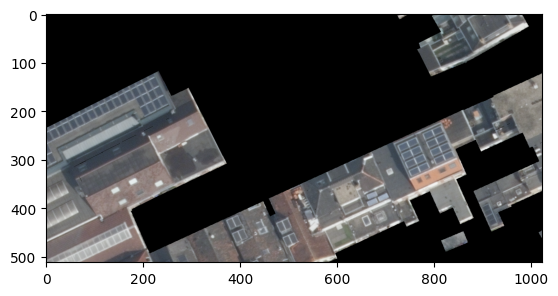

In [34]:
# Visualize the stack.
stack_bbox = dataset.bounds
plt.imshow(rasterio.plot.reshape_as_image(dataset[stack_bbox]["image"].numpy() / 255))

In [35]:
# Supposedly we have access to the stack...
# TODO
stack_width = 1024
stack_height = 512

transform = rasterio.transform.from_bounds(west=stack_bbox.minx,
                                           south=stack_bbox.miny,
                                           east=stack_bbox.maxx,
                                           north=stack_bbox.maxy,
                                           width=stack_width,
                                           height=stack_height)

In [36]:
from rasterio.features import geometry_mask

# Instantiate the map.
map_ = np.zeros([stack_height, stack_width], dtype=np.uint8)

x = 0
y = 0
for batch in tqdm.tqdm(dataloader):
    chips = batch["image"].to(model.device)
    # Scale the images to the range expected by the model.
    # NOTE: All general-purpose augmentations must be applied at this stage.
    chips /= 255

    # Infer the segmentation mask corresponding to each image.
    # NOTE: This context manager disables all automatic differentiation functionality.
    #      See https://stackoverflow.com/questions/74191070/why-there-are-two-different-flags-to-disable-gradient-computation-in-pytorch/74197846#74197846 for more information.
    with torch.inference_mode():
        masks = model(chips).argmax(dim=1).cpu().numpy()

    #----------
    # TODO
    # iterate through the batch and paste the predictions where they belong
    for i in range(BATCH_SIZE):
        bbox = batch["bbox"][i]
        # Create a polygon from the bbox
        geom = {
            "type": "Polygon",
            "coordinates": [
                [[bbox.minx, bbox.miny], [bbox.minx, bbox.maxy], [bbox.maxx, bbox.maxy], [bbox.maxx, bbox.miny],
                 [bbox.minx, bbox.miny]  # Close the loop
                 ]]}
        geom_mask = geometry_mask([geom], transform=transform, invert=True, out_shape=(stack_height, stack_width))
        map_[geom_mask] = masks[i].ravel()

  0%|          | 0/2 [00:06<?, ?it/s]


ValueError: NumPy boolean array indexing assignment cannot assign 262144 input values to the 131072 output values where the mask is true

In [ ]:
fig:plt.Figure
ax:plt.Axes
fig, ax = plt.subplots()

plot = ax.imshow(
    map_, 
    vmin=0, 
    vmax=len(dataset.cmap), 
    cmap=dataset._lc_cmap, 
    interpolation="None"
)

fig.colorbar(plot)

In [ ]:
surfs = gpd.read_file("../annotation/data/tmp/9-284-556.surfs.gpkg").dissolve()